In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith

In [ ]:
import getpass
import os
from dotenv import load_dotenv
# Load environment variables
import openai
from typing import Annotated

from sqlalchemy import create_engine
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langchain_core.messages import AIMessage, ToolMessage

from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import operator
import os
import csv
import openai
import re
import networkx as nx
from typing import Annotated, Any, List, Dict, Optional
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AIMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
import pandas as pd
# Set up OpenAI API key
import json

import sys
sys.path.append('/Users/philipnartschik/AIData/backend/app')
from config import Config
#from app.config import Config
load_dotenv()

# Set up OpenAI API key
openai.api_key = os.getenv('OPENAI_API_KEY')

engine = create_engine(Config.SQLALCHEMY_DATABASE_URI)
#check if the engine is working
print(engine.connect())



In [50]:
from sqlalchemy import text


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model='gpt-4o',max_tokens=500, temperature=0.0, n=1, stop=None)

llm_with_tools = llm.bind_tools(tools)
# Define the state schema with scripts and table_info fields
from typing import Dict

class State(TypedDict):
    scripts: Annotated[Dict[str, str], operator.or_]
    table_info: Annotated[Dict[str, dict], operator.or_]
    execution_order: List[str]
    error_messages: Annotated[List[str], operator.add]
    ask_human: bool
    known_tables: Annotated[List[str], operator.add]
    table_schemas: Annotated[List[dict], operator.add]
    table_foreign_keys: Dict[str, List[Dict[str, str]]]


class ParallelNode:
    def __init__(self, base_name: str, file_list: List[str], folder_path: str):
        self.base_name = base_name
        self.file_list = file_list  # List of CSV files to process
        self.folder_path = folder_path

    def __call__(self, state: State) -> Any:
        try:
            # Process only the first CSV file in the group
            filename = self.file_list[0]
            file_path = os.path.join(self.folder_path, filename)
            # Read CSV using pandas
            df = pd.read_csv(file_path, nrows=100)  # Read first 100 rows for efficiency
            if df.empty:
                error_message = f"No data found in file '{filename}' for table '{self.base_name}'"
                print(error_message)
                # Set flag to ask for human assistance
                return {
                    "error_messages": [error_message],
                    "ask_human": True,
                }
            # Get column data types
            column_types = df.dtypes.apply(lambda x: str(x)).to_dict()
            # Return the table schema to the supervisor
            table_schema = {
                "table_name": self.base_name,
                "columns": column_types,
            }
            print(f"Node processing table '{self.base_name}' extracted schema.")
            return {
                "table_schemas": [table_schema],
                # Return the updated known_tables
                "known_tables": [self.base_name],  # Return only the new table to be added
            }
        except Exception as e:
            # Handle exceptions and set flag to ask for human assistance
            error_message = f"Error in node '{self.base_name}': {str(e)}"
            print(error_message)
            return {
                "error_messages": [error_message],
                "ask_human": True,
            }

class GenerateScriptNode:
    def __init__(self, base_name: str):
        self.base_name = base_name
        # Local messages list for conversation history
        self.messages = []
    
    def __call__(self, state: State) -> Any:
        try:
            # Get the table schema and foreign keys
            table_schemas = state.get("table_schemas", [])
            table_foreign_keys = state.get("table_foreign_keys", {})
            # Find the schema for this table
            table_schema = next(schema for schema in table_schemas if schema['table_name'] == self.base_name)
            columns = table_schema['columns']
            foreign_keys = table_foreign_keys.get(self.base_name, [])
            known_tables = state.get('known_tables', [])
            # Prepare prompt with columns and foreign keys
            prompt = self.prepare_prompt(columns, foreign_keys, known_tables)
            # Call LLM to generate SQL script
            script = self.call_llm(prompt)
            # Extract primary keys and foreign keys from the script
            table_info = self.extract_keys(script)
            table_info['table_name'] = self.base_name
            return {
                "scripts": {self.base_name: script},
                "table_info": {self.base_name: table_info},
            }
        except Exception as e:
            error_message = f"Error generating script for table '{self.base_name}': {str(e)}"
            print(error_message)
            return {
                "error_messages": [error_message],
                "ask_human": True,
            }
    
    def prepare_prompt(self, columns: Dict[str, str], foreign_keys: List[Dict[str, str]], known_tables: List[str]) -> str:
        # Construct the prompt
        prompt = (
            f"Using the following table schema, generate a SQL CREATE TABLE script for a table named '{self.base_name}'. "
            f"Include appropriate data types, primary keys, and foreign key constraints. "
            f"Use double quotes around table and column names to preserve case sensitivity."
            f"Do not reference tables other than '{', '.join(known_tables)}'.\n\n"
            f"Columns and data types:\n"
        )
        for col_name, col_type in columns.items():
            prompt += f"- {col_name}: {col_type}\n"
        if foreign_keys:
            prompt += "\nForeign key relationships:\n"
            for fk in foreign_keys:
                prompt += (
                    f"- {fk['column']} references {fk['references']}({fk['referenced_column']})\n"
                )
        else:
            prompt += "\nNo foreign keys.\n"
        prompt += "\nPlease provide the syntactically correct SQL script that is runnable out of the box. Start without ```sql"
        return prompt

    def call_llm(self, prompt: str) -> str:
        # Initialize the LLM
        # Prepare messages
        self.messages = []
        self.messages.append({"role": "system", "content": "You are an expert SQL database designer."})
        self.messages.append({"role": "user", "content": prompt})
        # Invoke the LLM
        response = llm_with_tools.invoke(self.messages)
        # Update messages with the response
        self.messages.append(response)
        # Extract the content
        script = response.content.strip()
        return script

    def extract_keys(self, script: str) -> Dict[str, List[str]]:
        # Simple parsing of SQL script to extract primary and foreign keys
        primary_keys = []
        foreign_keys = []
        # Use regex to find PRIMARY KEY and FOREIGN KEY constraints
        pk_match = re.search(r'PRIMARY KEY\s*\((.*?)\)', script, re.IGNORECASE | re.DOTALL)
        if pk_match:
            pk_fields = pk_match.group(1)
            primary_keys = [field.strip(' `') for field in pk_fields.split(',')]
        fk_matches = re.findall(
            r'FOREIGN KEY\s*\((.*?)\)\s*REFERENCES\s*`?(\w+)`?\s*\((.*?)\)',
            script, re.IGNORECASE | re.DOTALL
        )
        for fk_field, ref_table, ref_field in fk_matches:
            foreign_keys.append(ref_table)
        return {'primary_keys': primary_keys, 'foreign_keys': foreign_keys}


def call_llm_for_foreign_keys(prompt: str) -> List[Dict[str, str]]:
    # Initialize the LLM
    # Prepare messages
    messages = [{"role": "system", "content": "You are an expert database analyst."},
                {"role": "user", "content": prompt}]
    # Invoke the LLM
    response = llm_with_tools.invoke(messages)
    print("LLM response:", response.content)
    # Extract the foreign key relationships from the response
    # Assuming the response is a JSON string
    try:
        foreign_keys = json.loads(response.content.strip())
    except json.JSONDecodeError as e:
        print(f"Error parsing LLM response: {e}")
        foreign_keys = []
    return foreign_keys



# Supervisor function to determine execution order based on dependencies
def supervisor(state: State) -> Any:
    table_schemas = state.get("table_schemas", [])
    user_context = "The tables are standard SAP tables and columns, and the data types are consistent with SAP data types. Use your knowledge of SAP tables to infer the foreign key relationships."
    known_tables = [schema['table_name'] for schema in table_schemas]
    # Prepare schema JSON
    schema_json = {schema['table_name']: schema['columns'] for schema in table_schemas}
    # Convert schema to compact JSON string
    schema_str = json.dumps(schema_json, separators=(',', ':'))
    # Prepare prompt for LLM
    prompt = (
        f"Given the following database schema in JSON format, identify the foreign key relationships "
        f"between tables based on matching column names and data types. "
        f"The following context is provided to help you infer foreign keys: {user_context}. "
        f"Provide the result only as a list of foreign key relationships in the format:\n"
        f"[\n"
        f"  {{'table': 'TableName', 'column': 'ColumnName', 'references': 'ReferencedTable', 'referenced_column': 'ReferencedColumn'}}\n"
        f"]\n\n The output should be directly parsable as JSON. Not even ```json\n\n"
        f"Schema JSON:\n{schema_str}"
    )
    # Call LLM to infer foreign keys
    foreign_keys = call_llm_for_foreign_keys(prompt)
    # Distribute foreign key information back to tables
    table_foreign_keys = {table_name: [] for table_name in known_tables}
    for fk in foreign_keys:
        table_foreign_keys[fk['table']].append(fk)
    # Build dependency graph
    G = nx.DiGraph()
    for table in known_tables:
        G.add_node(table)
    for fk in foreign_keys:
        if fk['references'] in known_tables:
            G.add_edge(fk['references'], fk['table'])
    # Perform topological sort
    try:
        execution_order = list(nx.topological_sort(G))
        print("Determined execution order:", execution_order)
    except nx.NetworkXUnfeasible:
        error_message = "Error: Cyclic dependency detected in foreign keys."
        print(error_message)
        return {
            "error_messages": [error_message],
            "ask_human": True,
        }
    # Update the state
    return {
        "table_foreign_keys": table_foreign_keys,
        "execution_order": execution_order,
        "table_schemas": table_schemas,
    }



def final_node(state: State) -> Any:
    scripts = state.get("scripts", {})
    table_infos = state.get("table_info", {})
    execution_order = state.get("execution_order", [])
    print("Executing scripts in the following order:")
    for table_name in execution_order:
        script = scripts[table_name]
        print(f"Executing script for table '{table_name}':\n{script}\n")
        try:
            with engine.connect() as connection:
                #catch the result of the execution
                result = connection.execute(text(script))
                connection.commit()
                print(f"Table '{table_name}' created successfully. {result}\n")
        except Exception as e:
            print(f"Error executing SQL script for table '{table_name}': {e}")
    return state




# Human-in-the-Loop node
def human_node(state: State) -> Any:
    error_messages = state.get("error_messages", [])
    print("Human intervention required.")
    for message in error_messages:
        print(f"Error: {message}")
    # Here, implement logic to allow human to resolve the issue
    # For example, fix the data, modify the prompt, or provide a corrected script
    # For the purpose of this example, we'll simulate human resolution
    resolved = False
    # Simulate human resolving the issue
    # In practice, you might read input from a human operator or perform some manual steps
    print("Simulating human resolution...")
    resolved = True  # Assume the issue is resolved
    if resolved:
        # Reset error messages and flags
        return {
            "error_messages": [],
            "ask_human": False,
            # You might update scripts or table_info here based on human input
        }
    else:
        # If not resolved, you might terminate or take other actions
        return {
            "ask_human": True,
        }

# Function to select the next node based on state
def select_next_node(state: State) -> str:
    if state.get("ask_human", False):
        return "human"
    else:
        return None  # Continue to the next node in the graph

# Function to group CSV files by base name
def group_csv_files(folder_path: str) -> Dict[str, List[str]]:
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    groups = {}
    for filename in csv_files:
        # Extract base name; e.g., for 'bse_1.csv' or 'bse_2.csv', base name is 'bse'
        base_name = filename.split('_')[0]
        if base_name not in groups:
            groups[base_name] = []
        groups[base_name].append(filename)
    return groups

# Initialize the graph
builder = StateGraph(State)

# Add the initial node
builder.add_node("initial", lambda state: state)
builder.add_edge(START, "initial")

# Provide the folder path
folder_path = '/Users/philipnartschik/Downloads/Demo'  # Replace with your actual folder path

# Group CSV files by base name
csv_groups = group_csv_files(folder_path)
# For testing, only have 4 csv_groups
csv_groups = {k: csv_groups[k] for k in list(csv_groups)[:4]}

# Dynamically add parallel nodes based on the number of base names
for base_name, file_list in csv_groups.items():
    node_name = f"parallel_{base_name}"
    builder.add_node(node_name, ParallelNode(base_name, file_list, folder_path))
    builder.add_edge("initial", node_name)
    # Edge to supervisor
    builder.add_edge(node_name, "supervisor")

# Add the supervisor node
builder.add_node("supervisor", supervisor)

# Add the script generation nodes
for base_name in csv_groups.keys():
    node_name = f"generate_{base_name}"
    builder.add_node(node_name, GenerateScriptNode(base_name))
    builder.add_edge("supervisor", node_name)
    # Edge to final node
    builder.add_edge(node_name, "final")

# Add the final node
builder.add_node("final", final_node)
builder.add_edge("final", END)

# Compile the graph
memory = MemorySaver()
graph = builder.compile(
#    checkpointer=memory,
)

# Execute the graph with the initial state
initial_state = {
    "scripts": {},           # Changed from [] to {}
    "table_info": {},        # Changed from [] to {}
    "execution_order": [],
    "error_messages": [],
    "ask_human": False,
    "known_tables": [],
    "table_schemas": [],     # Ensure this is included if used
}
graph.invoke(initial_state)




Node processing table 'BSEG' extracted schema.Node processing table 'LFA1' extracted schema.
Node processing table 'T16FG' extracted schema.
Node processing table 'BKPF' extracted schema.

LLM response: [
  {"table": "BSEG", "column": "BELNR", "references": "BKPF", "referenced_column": "BELNR"},
  {"table": "BSEG", "column": "BUKRS", "references": "BKPF", "referenced_column": "BUKRS"},
  {"table": "BSEG", "column": "GJAHR", "references": "BKPF", "referenced_column": "GJAHR"},
  {"table": "BSEG", "column": "MANDT", "references": "BKPF", "referenced_column": "MANDT"},
  {"table": "BSEG", "column": "LIFNR", "references": "LFA1", "referenced_column": "LIFNR"},
  {"table": "BSEG", "column": "MANDT", "references": "LFA1", "referenced_column": "MANDT"}
]
Determined execution order: ['BKPF', 'LFA1', 'T16FG', 'BSEG']
Executing scripts in the following order:
Executing script for table 'BKPF':
CREATE TABLE "BKPF" (
    "AEDAT" VARCHAR(255),
    "AWKEY" VARCHAR(255),
    "AWTYP" VARCHAR(255),
   

{'scripts': {'BSEG': 'CREATE TABLE "BSEG" (\n    "AUGBL" VARCHAR(20),\n    "AUGCP" VARCHAR(20),\n    "AUGDT" DATE,\n    "AUGGJ" INTEGER,\n    "BELNR" VARCHAR(10),\n    "BSCHL" VARCHAR(2),\n    "BUKRS" VARCHAR(4),\n    "BUZEI" INTEGER,\n    "BUZID" VARCHAR(4),\n    "DMBTR" DECIMAL(15, 2),\n    "GJAHR" INTEGER,\n    "KOART" VARCHAR(2),\n    "KUNNR" VARCHAR(10),\n    "LIFNR" VARCHAR(10),\n    "MABER" VARCHAR(4),\n    "MADAT" DATE,\n    "MANDT" VARCHAR(3),\n    "MANSP" VARCHAR(1),\n    "MANST" VARCHAR(1),\n    "MENGE" DECIMAL(15, 3),\n    "MSCHL" VARCHAR(2),\n    "MWSKZ" VARCHAR(2),\n    "NETDT" DATE,\n    "PRCTR" VARCHAR(10),\n    "PSWBT" DECIMAL(15, 2),\n    "REBZG" VARCHAR(10),\n    "REBZJ" INTEGER,\n    "REBZZ" VARCHAR(2),\n    "SAKNR" VARCHAR(10),\n    "SGTXT" VARCHAR(50),\n    "SHKZG" VARCHAR(1),\n    "SK1DT" DATE,\n    "SK2DT" DATE,\n    "SKFBT" DECIMAL(15, 2),\n    "SKNTO" VARCHAR(10),\n    "WRBTR" DECIMAL(15, 2),\n    "WSKTO" DECIMAL(15, 2),\n    "ZBD1P" INTEGER,\n    "ZBD1T" DATE

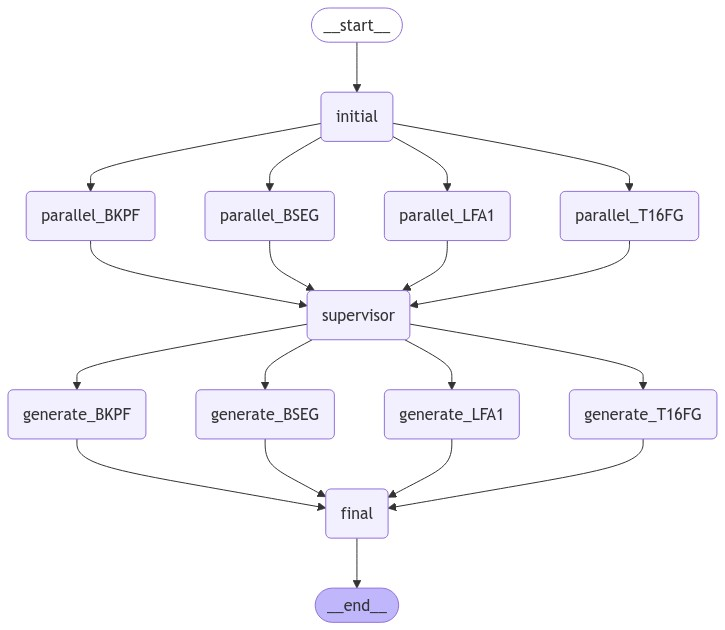

In [26]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

config = {"configurable": {"thread_id": "1"}}